In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import csv
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt

Import filtered cardiac data

In [2]:
adata_cardiac = sc.read_h5ad("scanpy.pseudotime.h5ad")

In [3]:
adata_cardiac

AnnData object with n_obs × n_vars = 211630 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'diffday', 'individual', 'percent.mito', 'sample', 'SNG.1ST', 'PRB.DBL', 'round', 'CD', 'col', 'individual_try2', 'diffday_try2', 'sample_try2', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'PC1', 'leiden', 'type', 'dpt_pseudotime'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'mean', 'std'
    uns: 'diffday_colors', 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'type_colors', 'type_sizes', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log.data', 'scale.data'
    obsp: 'connectivities', 'distances'

In [4]:
adata_cardiac.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,diffday,individual,percent.mito,sample,SNG.1ST,PRB.DBL,round,...,G2M.Score,Phase,old.ident,CC.Difference,nCount_SCT,nFeature_SCT,PC1,leiden,type,dpt_pseudotime
E1_E1CD1col1_AAAAAACAATAA,E1CD1col1,3887.0,1757,day1,18520,19.114999,18520_1,NA18520,3.390000e-17,1,...,-0.607138,G1,NA18520.Day 1,0.166064,2744.0,1699,-4.478271,0,MES,0.035307
E1_E1CD1col1_AAAAAACACAGA,E1CD1col1,3831.0,1675,day3,18912,12.633777,18912_3,NA18912,2.000000e-16,1,...,-0.374630,G1,NA18912.Day 3,0.067234,2717.0,1631,-3.765478,5,CMES,0.351027
E1_E1CD1col1_AAAAAAGCCGGC,E1CD1col1,2694.0,1350,day3,18912,9.873794,18912_3,NA18912,1.750000e-12,1,...,0.181656,G2M,NA18912.Day 3,-0.571609,2494.0,1350,-3.735700,5,CMES,0.379476
E1_E1CD1col1_AAAAACACCCGT,E1CD1col1,2592.0,1353,day7,19093,9.490741,19093_7,NA19093,2.550000e-10,1,...,0.589722,G2M,NA19093.Day 7,-0.694183,2458.0,1353,3.837809,1,CM,0.352699
E1_E1CD1col1_AAAAAGAGTTTA,E1CD1col1,6091.0,2169,day7,19093,24.261326,19093_7,NA19093,9.670000e-28,1,...,-1.548179,G1,NA19093.Day 7,0.413170,2707.0,1373,24.702881,4,CF,0.911929


List of individuals in data set

In [5]:
np.unique(adata_cardiac.obs["individual"])

array(['18489', '18499', '18505', '18508', '18511', '18517', '18520',
       '18855', '18858', '18870', '18907', '18912', '19093', '19108',
       '19127', '19159', '19190', '19193', '19209'], dtype=object)

List of genes in data set

In [6]:
adata_cardiac.var_names

Index(['AFP', 'EMC10', 'APOA2', 'MYL7', 'NPPA', 'ANKRD1', 'APOA1', 'TTR',
       'SERPINA1', 'FGB',
       ...
       'MITF', 'FGF9', 'TMEM176B', 'ARHGDIB', 'GIPR', 'FABP2', 'ZEB1',
       'AKR1C2', 'AUXG01000058.1', 'CLIC3'],
      dtype='object', length=1000)

# Classifying on D15 Data

The dataset has both scaled and log counts. In principle, there should not be a huge difference in how well regression works using these two data types, but I want to test both

## Logistic Regression on Scaled Counts

Extract scaled counts 

Save column names and individuals as variables

In [7]:
scale_data = adata_cardiac.to_df('scale.data')
colnames = scale_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

Extract day 0 IPSCs and average their scaled counts by line

In [8]:
df = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i), :].to_df()
    df.loc[i]=np.mean(row)

In [9]:
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,-0.110838,-0.218040,-0.150681,-0.268384,-0.125557,-0.227098,-0.182926,-0.119727,-0.069960,-0.104856,...,-0.122608,-0.065772,-0.038192,-0.096593,-0.084359,-0.013633,-0.217864,-0.045615,-0.141902,-0.069393
18499,-0.127608,-0.249751,-0.134842,-0.274736,-0.129603,-0.223854,-0.162760,-0.111129,-0.071822,-0.094158,...,-0.139943,-0.050205,-0.047590,-0.106203,-0.075941,-0.013311,-0.223172,-0.004152,-0.147756,-0.070085
18505,-0.081623,-0.242317,-0.089985,-0.268787,-0.130950,-0.234209,-0.147713,-0.098079,-0.067720,-0.039227,...,-0.118118,-0.026609,-0.047148,-0.101435,-0.080971,-0.012902,-0.231431,-0.027804,-0.135541,-0.068816
18508,-0.059166,-0.201956,0.039385,-0.233148,-0.118524,-0.207934,-0.129836,0.088220,-0.035133,-0.077993,...,-0.107489,-0.048867,-0.029580,-0.098396,-0.078853,-0.014057,-0.204065,-0.048064,-0.125791,-0.071785
18511,-0.020869,-0.067516,-0.128540,-0.209023,-0.072771,-0.213031,-0.178733,-0.106110,-0.077477,-0.106431,...,-0.117719,-0.068260,-0.025984,-0.088926,-0.082391,-0.013840,-0.202400,-0.025318,-0.132369,-0.064012


In [10]:
df.index

Index(['18489', '18499', '18505', '18508', '18511', '18517', '18520', '18855',
       '18858', '18870', '18907', '18912', '19093', '19108', '19127', '19159',
       '19190', '19193', '19209'],
      dtype='object')

Extract column names and samples for implementation of logistic regression model later. This is a super obvious point, but it's critical to do this NOW, prior to addition of cm_biased columns so that those are not included as features.

In [11]:
samples = list(df.index)
feature_list = list(df.columns)

Based of list CM biased lines (>50% of cells are CM at day 15), annotate data frame.

In [12]:
cm_biased=["18520", "19093", "18508", "18511", "18907", "19190", "18855", "19159", "19127"]
df['cm_biased'] = np.where(np.isin(df.index, cm_biased), 1, 0)
df['cm_not_biased'] = np.where(np.isin(df.index, cm_biased, invert=True), 1, 0)

Do the same for cf bias

In [13]:
cf_biased=["18912", "18858", "18505", "18489", "18517", "19193", "19108"]
df['cf_biased'] = np.where(np.isin(df.index, cf_biased), 1, 0)
df['cf_not_biased'] = np.where(np.isin(df.index, cf_biased, invert=True), 1, 0)

In [14]:
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased,cf_biased,cf_not_biased
18489,-0.110838,-0.218040,-0.150681,-0.268384,-0.125557,-0.227098,-0.182926,-0.119727,-0.069960,-0.104856,...,-0.084359,-0.013633,-0.217864,-0.045615,-0.141902,-0.069393,0,1,1,0
18499,-0.127608,-0.249751,-0.134842,-0.274736,-0.129603,-0.223854,-0.162760,-0.111129,-0.071822,-0.094158,...,-0.075941,-0.013311,-0.223172,-0.004152,-0.147756,-0.070085,0,1,0,1
18505,-0.081623,-0.242317,-0.089985,-0.268787,-0.130950,-0.234209,-0.147713,-0.098079,-0.067720,-0.039227,...,-0.080971,-0.012902,-0.231431,-0.027804,-0.135541,-0.068816,0,1,1,0
18508,-0.059166,-0.201956,0.039385,-0.233148,-0.118524,-0.207934,-0.129836,0.088220,-0.035133,-0.077993,...,-0.078853,-0.014057,-0.204065,-0.048064,-0.125791,-0.071785,1,0,0,1
18511,-0.020869,-0.067516,-0.128540,-0.209023,-0.072771,-0.213031,-0.178733,-0.106110,-0.077477,-0.106431,...,-0.082391,-0.013840,-0.202400,-0.025318,-0.132369,-0.064012,1,0,0,1


Define logistic regression method

In [15]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

### Regression on CM Bias

In [16]:
diff_measure = 'cm_biased'
x = df.loc[samples,feature_list].values
y = df.loc[samples,diff_measure].values

In [17]:
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

In [18]:
y_pred_prob_list

[0.4838404189257215,
 0.214088291029574,
 0.41242309550352035,
 0.8246792714574598,
 0.44815616318376084,
 0.350267313617012,
 0.3266947396831383,
 0.3471352377533806,
 0.7835162086438522,
 0.27678843786845714,
 0.7518998174577209,
 0.6861472185535233,
 0.794090290027601,
 0.6169682372172176,
 0.24632660650491933,
 0.8665258156194918,
 0.6185896070406665,
 0.624195513234717,
 0.23269104271494898]

(array([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.]),
 array([0.21408829, 0.22713704, 0.24018579, 0.25323454, 0.26628329,
        0.27933204, 0.29238079, 0.30542954, 0.31847829, 0.33152705,
        0.3445758 , 0.35762455, 0.3706733 , 0.38372205, 0.3967708 ,
        0.40981955, 0.4228683 , 0.43591705, 0.4489658 , 0.46201455,
        0.4750633 , 0.48811205, 0.5011608 , 0.51420955, 0.5272583 ,
        0.54030705, 0.5533558 , 0.56640455, 0.5794533 , 0.59250206,
        0.60555081, 0.61859956, 0.63164831, 0.64469706, 0.65774581,
        0.67079456, 0.68384331, 0.69689206, 0.70994081, 0.72298956,
        0.73603831, 0.74908706, 0.76213581, 0.77518456, 0.78823331,
        0.80128206, 0.81433081, 0.82737956, 0.84042831, 0.85347707,
        0.86652582]),
 <BarContainer object of 50 artists>)

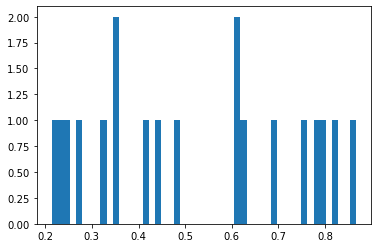

In [19]:
plt.hist(y_pred_prob_list, bins=50)

In [20]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes']

In [21]:
good, bad

(11, 8)

### Regression on CF Bias

In [22]:
diff_measure = 'cf_biased'
x = df.loc[samples,feature_list].values
y = df.loc[samples,diff_measure].values

In [23]:
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

In [24]:
y_pred_prob_list

[0.2123957591388109,
 0.31671390147369105,
 0.3898425009011728,
 0.16169110343506515,
 0.2771731768816128,
 0.49893673518433684,
 0.30959743901296227,
 0.7166028537652149,
 0.356407282204236,
 0.3850539548323404,
 0.43957943726684895,
 0.28861667275329017,
 0.31265516121515713,
 0.18442493237693872,
 0.313086323462954,
 0.46322523711396635,
 0.3610818386365499,
 0.39657656450889117,
 0.4610125831370492]

(array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 4., 0., 0., 0.,
        2., 0., 0., 2., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.1616911 , 0.17278934, 0.18388757, 0.19498581, 0.20608404,
        0.21718228, 0.22828051, 0.23937875, 0.25047698, 0.26157522,
        0.27267345, 0.28377169, 0.29486992, 0.30596816, 0.31706639,
        0.32816463, 0.33926286, 0.3503611 , 0.36145933, 0.37255757,
        0.3836558 , 0.39475404, 0.40585227, 0.41695051, 0.42804874,
        0.43914698, 0.45024521, 0.46134345, 0.47244168, 0.48353992,
        0.49463815, 0.50573639, 0.51683462, 0.52793286, 0.53903109,
        0.55012933, 0.56122756, 0.5723258 , 0.58342403, 0.59452227,
        0.6056205 , 0.61671874, 0.62781697, 0.63891521, 0.65001344,
        0.66111168, 0.67220991, 0.68330815, 0.69440638, 0.70550462,
        0.71660285]),
 <BarContainer object of 50 artists>)

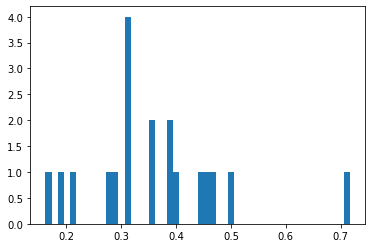

In [25]:
plt.hist(y_pred_prob_list, bins=50)

In [26]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'yes']

In [27]:
good, bad

(11, 8)

Now repeating the above procedure, except on log counts:

## Logistic Regression on Log Counts

In [3]:
adata_cardiac

AnnData object with n_obs × n_vars = 211630 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'diffday', 'individual', 'percent.mito', 'sample', 'SNG.1ST', 'PRB.DBL', 'round', 'CD', 'col', 'individual_try2', 'diffday_try2', 'sample_try2', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'PC1', 'leiden', 'type', 'dpt_pseudotime'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'mean', 'std'
    uns: 'diffday_colors', 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'type_colors', 'type_sizes', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log.data', 'scale.data'
    obsp: 'connectivities', 'distances'

In [4]:
log_data = adata_cardiac.to_df('log.data')
colnames = log_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

As above, except this time extract the log.data layer

In [5]:
df_log = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i), :].to_df(layer='log.data')
    row_exp = np.expm1(row)
    row=np.sum(row_exp)
    df_log.loc[i]=np.log(row.replace(0, np.nan))
    df_log=df_log.fillna(0)

In [6]:
df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,3.258096,6.905753,1.386294,5.416101,3.433987,4.094345,1.791759,0.000000,0.000000,0.000000,...,1.609438,0.000000,0.000000,0.000000,0.000000,0.0,0.693147,0.000000,1.609438,0.0
18499,2.484907,5.318120,0.000000,4.941642,3.091043,4.624973,2.079442,0.000000,0.000000,0.000000,...,0.693147,1.386294,0.000000,0.000000,1.098612,0.0,2.079442,1.098612,1.791759,0.0
18505,3.332205,5.407172,1.791759,4.836282,2.397895,2.079442,1.386294,0.000000,0.000000,1.609438,...,1.945910,1.609438,0.000000,0.000000,0.000000,0.0,1.386294,0.693147,1.098612,0.0
18508,4.718499,7.707063,4.672829,7.120444,4.624973,5.968708,4.158883,4.465908,2.302585,2.564949,...,2.944439,1.945910,1.609438,1.098612,1.098612,0.0,3.044523,0.000000,3.044523,0.0
18511,5.017280,8.778172,2.995732,7.421776,5.752573,5.746203,3.044523,2.302585,0.000000,0.693147,...,2.772589,0.000000,1.386294,1.791759,1.098612,0.0,3.135494,1.609438,2.833213,0.0


In [7]:
samples = list(df_log.index)
feature_list = list(df_log.columns)

In [8]:
cm_biased=["18520", "19093", "18508", "18511", "18907", "19190", "18855", "19159", "19127"]
df_log['cm_biased'] = np.where(np.isin(df_log.index, cm_biased), 1, 0)
df_log['cm_not_biased'] = np.where(np.isin(df_log.index, cm_biased, invert=True), 1, 0)

cf_biased=["18912", "18858", "18505", "18489", "18517", "19193", "19108"]
df_log['cf_biased'] = np.where(np.isin(df_log.index, cf_biased), 1, 0)
df_log['cf_not_biased'] = np.where(np.isin(df_log.index, cf_biased, invert=True), 1, 0)

In [9]:
df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased,cf_biased,cf_not_biased
18489,3.258096,6.905753,1.386294,5.416101,3.433987,4.094345,1.791759,0.000000,0.000000,0.000000,...,0.000000,0.0,0.693147,0.000000,1.609438,0.0,0,1,1,0
18499,2.484907,5.318120,0.000000,4.941642,3.091043,4.624973,2.079442,0.000000,0.000000,0.000000,...,1.098612,0.0,2.079442,1.098612,1.791759,0.0,0,1,0,1
18505,3.332205,5.407172,1.791759,4.836282,2.397895,2.079442,1.386294,0.000000,0.000000,1.609438,...,0.000000,0.0,1.386294,0.693147,1.098612,0.0,0,1,1,0
18508,4.718499,7.707063,4.672829,7.120444,4.624973,5.968708,4.158883,4.465908,2.302585,2.564949,...,1.098612,0.0,3.044523,0.000000,3.044523,0.0,1,0,0,1
18511,5.017280,8.778172,2.995732,7.421776,5.752573,5.746203,3.044523,2.302585,0.000000,0.693147,...,1.098612,0.0,3.135494,1.609438,2.833213,0.0,1,0,0,1


Define logistic regression method

In [10]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

### Regression on CM Bias

In [11]:
diff_measure = 'cm_biased'
x = df_log.loc[samples,feature_list].values
y = df_log.loc[samples,diff_measure].values

In [12]:
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

In [13]:
y_pred_prob_list

[0.6787587379096635,
 0.16410090145269657,
 0.13301561917145321,
 0.14075126859649534,
 0.13497420051968312,
 0.8798476708334462,
 0.12770333364220998,
 0.3224341225215241,
 0.7749876259813192,
 0.497548363120153,
 0.5209271807920262,
 0.7032985495012312,
 0.49610032471079313,
 0.7585115312365366,
 0.4685683016874925,
 0.5460623413920462,
 0.6071131475417398,
 0.7038937933983521,
 0.06376421721359252]

(array([1., 0., 0., 1., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.06376422, 0.08008589, 0.09640756, 0.11272922, 0.12905089,
        0.14537256, 0.16169423, 0.1780159 , 0.19433757, 0.21065924,
        0.22698091, 0.24330258, 0.25962425, 0.27594592, 0.29226758,
        0.30858925, 0.32491092, 0.34123259, 0.35755426, 0.37387593,
        0.3901976 , 0.40651927, 0.42284094, 0.43916261, 0.45548427,
        0.47180594, 0.48812761, 0.50444928, 0.52077095, 0.53709262,
        0.55341429, 0.56973596, 0.58605763, 0.6023793 , 0.61870097,
        0.63502263, 0.6513443 , 0.66766597, 0.68398764, 0.70030931,
        0.71663098, 0.73295265, 0.74927432, 0.76559599, 0.78191766,
        0.79823933, 0.81456099, 0.83088266, 0.84720433, 0.863526  ,
        0.87984767]),
 <BarContainer object of 50 artists>)

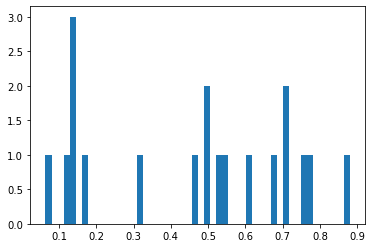

In [14]:
plt.hist(y_pred_prob_list, bins=50)

In [15]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes']

In [16]:
good, bad

(7, 12)

(0.0, 1.01)

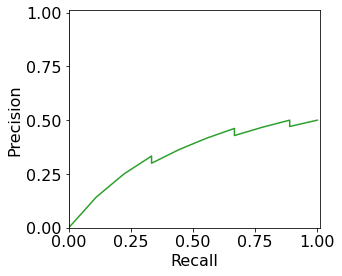

In [17]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
fig = plt.figure(figsize=(4.5,4))

plt.plot(recall, precision, '-', color='#2ca02c')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(np.arange(0,1.01,0.25), fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
plt.xlim([0,1.01])
plt.ylim([0.0,1.01])

### Regression on CF Bias

In [18]:
diff_measure = 'cf_biased'
x = df_log.loc[samples,feature_list].values
y = df_log.loc[samples,diff_measure].values

In [19]:
n_samples = x.shape[0]
predictions=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1])]

In [20]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no']

In [21]:
good, bad

(7, 12)

The above method performs terribly. Trying to average log counts instead: 

## Averaging Logs

In [22]:
log_data = adata_cardiac.to_df('log.data')
colnames = log_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [23]:
df_log = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i), :].to_df(layer='log.data')
    df_log.loc[i]=np.mean(row)

In [24]:
df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,0.008157,0.175639,0.001275,0.054704,0.009222,0.015991,0.001913,0.000000,0.000000,0.000000,...,0.001594,0.000319,0.000319,0.000319,0.000319,0.0,0.000638,0.000000,0.001594,0.000000
18499,0.003995,0.059263,0.000000,0.031051,0.006579,0.027928,0.002759,0.000000,0.000000,0.000000,...,0.000690,0.001379,0.000000,0.000000,0.001035,0.0,0.002473,0.001035,0.002069,0.000000
18505,0.011980,0.066612,0.002163,0.043630,0.004248,0.003261,0.001631,0.000000,0.000000,0.001897,...,0.002806,0.002274,0.000000,0.000455,0.000000,0.0,0.001631,0.000721,0.001364,0.000000
18508,0.021178,0.283643,0.020196,0.185385,0.018196,0.065277,0.012285,0.016341,0.001927,0.002447,...,0.003737,0.001324,0.001005,0.000603,0.000603,0.0,0.003889,0.000000,0.004223,0.000000
18511,0.030839,0.722181,0.003961,0.254535,0.057813,0.055122,0.004446,0.001981,0.000000,0.000342,...,0.003240,0.000216,0.000864,0.001296,0.000648,0.0,0.004516,0.000901,0.003672,0.000216


In [25]:
samples = list(df_log.index)
feature_list = list(df_log.columns)

cm_biased=["18520", "19093", "18508", "18511", "18907", "19190", "18855", "19159", "19127"]
df_log['cm_biased'] = np.where(np.isin(df_log.index, cm_biased), 1, 0)
df_log['cm_not_biased'] = np.where(np.isin(df_log.index, cm_biased, invert=True), 1, 0)

cf_biased=["18912", "18858", "18505", "18489", "18517", "19193", "19108"]
df_log['cf_biased'] = np.where(np.isin(df_log.index, cf_biased), 1, 0)
df_log['cf_not_biased'] = np.where(np.isin(df_log.index, cf_biased, invert=True), 1, 0)

df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased,cf_biased,cf_not_biased
18489,0.008157,0.175639,0.001275,0.054704,0.009222,0.015991,0.001913,0.000000,0.000000,0.000000,...,0.000319,0.0,0.000638,0.000000,0.001594,0.000000,0,1,1,0
18499,0.003995,0.059263,0.000000,0.031051,0.006579,0.027928,0.002759,0.000000,0.000000,0.000000,...,0.001035,0.0,0.002473,0.001035,0.002069,0.000000,0,1,0,1
18505,0.011980,0.066612,0.002163,0.043630,0.004248,0.003261,0.001631,0.000000,0.000000,0.001897,...,0.000000,0.0,0.001631,0.000721,0.001364,0.000000,0,1,1,0
18508,0.021178,0.283643,0.020196,0.185385,0.018196,0.065277,0.012285,0.016341,0.001927,0.002447,...,0.000603,0.0,0.003889,0.000000,0.004223,0.000000,1,0,0,1
18511,0.030839,0.722181,0.003961,0.254535,0.057813,0.055122,0.004446,0.001981,0.000000,0.000342,...,0.000648,0.0,0.004516,0.000901,0.003672,0.000216,1,0,0,1


In [26]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

### Regression on CM Bias

diff_measure = 'cm_biased'
x = df_log.loc[samples,feature_list].values
y = df_log.loc[samples,diff_measure].values

n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0])]

In [27]:
y_pred_prob_list

[0.49483406651681267,
 0.43386565038849845,
 0.5444943991045404,
 0.5160474645046512,
 0.5050509013357452,
 0.5120098887237794,
 0.46564323075639885,
 0.4516531907985461,
 0.56205833859446,
 0.4459831056601971,
 0.48593094592033265,
 0.6782283235858244,
 0.5304384903687188,
 0.5011947449298428,
 0.2896298860450462,
 0.4021705454741245,
 0.5389093698594167,
 0.5002457271878256,
 0.450696483386838]

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 3., 0., 1., 0., 0., 1., 1., 3., 1., 1., 1., 0., 2., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.28962989, 0.29740185, 0.30517382, 0.31294579, 0.32071776,
        0.32848973, 0.3362617 , 0.34403367, 0.35180564, 0.3595776 ,
        0.36734957, 0.37512154, 0.38289351, 0.39066548, 0.39843745,
        0.40620942, 0.41398139, 0.42175335, 0.42952532, 0.43729729,
        0.44506926, 0.45284123, 0.4606132 , 0.46838517, 0.47615714,
        0.4839291 , 0.49170107, 0.49947304, 0.50724501, 0.51501698,
        0.52278895, 0.53056092, 0.53833289, 0.54610485, 0.55387682,
        0.56164879, 0.56942076, 0.57719273, 0.5849647 , 0.59273667,
        0.60050864, 0.6082806 , 0.61605257, 0.62382454, 0.63159651,
        0.63936848, 0.64714045, 0.65491242, 0.66268439, 0.67045635,
        0.67822832]),
 <BarContainer object of 50 artists>)

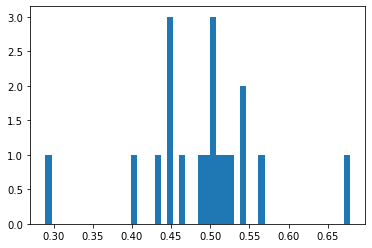

In [28]:
plt.hist(y_pred_prob_list, bins=50)

In [29]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'yes']

In [30]:
good, bad

(8, 11)

(0.0, 1.01)

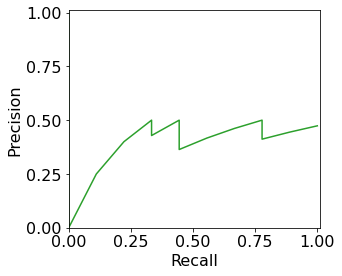

In [31]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
fig = plt.figure(figsize=(4.5,4))

plt.plot(recall, precision, '-', color='#2ca02c')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(np.arange(0,1.01,0.25), fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
plt.xlim([0,1.01])
plt.ylim([0.0,1.01])

## Summing Logs but not the right way

i.e. just taking the sum of the logs, which is actuallly the product of the terms within the logs

In [32]:
adata_cardiac

AnnData object with n_obs × n_vars = 211630 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'diffday', 'individual', 'percent.mito', 'sample', 'SNG.1ST', 'PRB.DBL', 'round', 'CD', 'col', 'individual_try2', 'diffday_try2', 'sample_try2', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'PC1', 'leiden', 'type', 'dpt_pseudotime'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'mean', 'std'
    uns: 'diffday_colors', 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'type_colors', 'type_sizes', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log.data', 'scale.data'
    obsp: 'connectivities', 'distances'

In [33]:
log_data = adata_cardiac.to_df('log.data')
colnames = log_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [34]:
df_log = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i), :].to_df(layer='log.data')
    df_log.loc[i]=np.sum(row)

df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,17.734150,381.839539,2.772589,118.925598,20.049156,34.763851,4.158883,0.000000,0.00000,0.000000,...,3.465736,0.693147,0.693147,0.693147,0.693147,0.0,1.386294,0.000000,3.465736,0.000000
18499,8.030085,119.119209,0.000000,62.412525,13.223043,56.135868,5.545177,0.000000,0.00000,0.000000,...,1.386294,2.772589,0.000000,0.000000,2.079442,0.0,4.969813,2.079442,4.158883,0.000000
18505,18.257399,101.516777,3.295837,66.492279,6.473891,4.969813,2.484907,0.000000,0.00000,2.890372,...,4.276666,3.465736,0.000000,0.693147,0.000000,0.0,2.484907,1.098612,2.079442,0.000000
18508,73.000221,977.718323,69.615921,639.023376,62.720821,225.011215,42.347637,56.328342,6.64379,8.435549,...,12.882118,4.564348,3.465736,2.079442,2.079442,0.0,13.405363,0.000000,14.556095,0.000000
18511,98.963600,2317.478027,12.712217,816.803589,185.520493,176.886078,14.268412,6.356108,0.00000,1.098612,...,10.397209,0.693147,2.772589,4.158883,2.079442,0.0,14.491556,2.890372,11.783504,0.693147


In [35]:
samples = list(df_log.index)
feature_list = list(df_log.columns)
cm_biased=["18520", "19093", "18508", "18511", "18907", "19190", "18855", "19159", "19127"]
df_log['cm_biased'] = np.where(np.isin(df_log.index, cm_biased), 1, 0)
df_log['cm_not_biased'] = np.where(np.isin(df_log.index, cm_biased, invert=True), 1, 0)

cf_biased=["18912", "18858", "18505", "18489", "18517", "19193", "19108"]
df_log['cf_biased'] = np.where(np.isin(df_log.index, cf_biased), 1, 0)
df_log['cf_not_biased'] = np.where(np.isin(df_log.index, cf_biased, invert=True), 1, 0)
df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased,cf_biased,cf_not_biased
18489,17.734150,381.839539,2.772589,118.925598,20.049156,34.763851,4.158883,0.000000,0.00000,0.000000,...,0.693147,0.0,1.386294,0.000000,3.465736,0.000000,0,1,1,0
18499,8.030085,119.119209,0.000000,62.412525,13.223043,56.135868,5.545177,0.000000,0.00000,0.000000,...,2.079442,0.0,4.969813,2.079442,4.158883,0.000000,0,1,0,1
18505,18.257399,101.516777,3.295837,66.492279,6.473891,4.969813,2.484907,0.000000,0.00000,2.890372,...,0.000000,0.0,2.484907,1.098612,2.079442,0.000000,0,1,1,0
18508,73.000221,977.718323,69.615921,639.023376,62.720821,225.011215,42.347637,56.328342,6.64379,8.435549,...,2.079442,0.0,13.405363,0.000000,14.556095,0.000000,1,0,0,1
18511,98.963600,2317.478027,12.712217,816.803589,185.520493,176.886078,14.268412,6.356108,0.00000,1.098612,...,2.079442,0.0,14.491556,2.890372,11.783504,0.693147,1,0,0,1


In [36]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

### Regression on CM Bias

In [37]:
diff_measure = 'cm_biased'
x = df_log.loc[samples,feature_list].values
y = df_log.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0])]

In [38]:
y_pred_prob_list

[0.999997363810406,
 6.0556591604535706e-09,
 0.9595971085353366,
 0.999999999983598,
 0.9999999368474433,
 3.847307082342427e-05,
 0.2798785791376979,
 0.0022163894804581416,
 0.999999998461407,
 0.001361123680242407,
 0.5111583342267952,
 0.9839425470220134,
 0.9997580513086777,
 0.013744668694200534,
 0.9462249972947059,
 0.9999999942834497,
 0.9999999999834455,
 0.0004052460436230256,
 2.634421789733962e-07]

In [39]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1
        
matches

['no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes']

In [40]:
good, bad

(13, 6)

(0.0, 1.01)

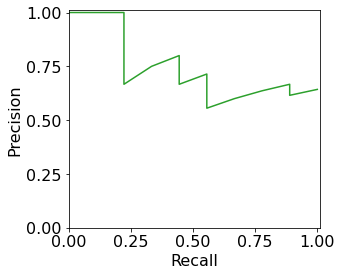

In [41]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
fig = plt.figure(figsize=(4.5,4))

plt.plot(recall, precision, '-', color='#2ca02c')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(np.arange(0,1.01,0.25), fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
plt.xlim([0,1.01])
plt.ylim([0.0,1.01])
(0.0, 1.01)

### Regression on CF Bias

In [42]:
diff_measure = 'cf_biased'
x = df_log.loc[samples,feature_list].values
y = df_log.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1])]

In [43]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'no']

In [44]:
good, bad

(10, 9)

Overall, these log-based methods perform quite poorly. Going forward, I will rely primarily on scaled data. 

# Based on D11

The above analyses range from performing slightly worse than random choice to performin a bit better. Looking at the plots of cell type proportions in the R notebook, I noticed that a number of cell line adopt a cell fate in d7/11 and then change it in d15. Therefore, I want to try classifying based on D11 cell type proportions

## Scaled Data

In [45]:
scale_data = adata_cardiac.to_df('scale.data')
colnames = scale_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [46]:
df = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i), :].to_df()
    df.loc[i]=np.mean(row)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,-0.110838,-0.218040,-0.150681,-0.268384,-0.125557,-0.227098,-0.182926,-0.119727,-0.069960,-0.104856,...,-0.122608,-0.065772,-0.038192,-0.096593,-0.084359,-0.013633,-0.217864,-0.045615,-0.141902,-0.069393
18499,-0.127608,-0.249751,-0.134842,-0.274736,-0.129603,-0.223854,-0.162760,-0.111129,-0.071822,-0.094158,...,-0.139943,-0.050205,-0.047590,-0.106203,-0.075941,-0.013311,-0.223172,-0.004152,-0.147756,-0.070085
18505,-0.081623,-0.242317,-0.089985,-0.268787,-0.130950,-0.234209,-0.147713,-0.098079,-0.067720,-0.039227,...,-0.118118,-0.026609,-0.047148,-0.101435,-0.080971,-0.012902,-0.231431,-0.027804,-0.135541,-0.068816
18508,-0.059166,-0.201956,0.039385,-0.233148,-0.118524,-0.207934,-0.129836,0.088220,-0.035133,-0.077993,...,-0.107489,-0.048867,-0.029580,-0.098396,-0.078853,-0.014057,-0.204065,-0.048064,-0.125791,-0.071785
18511,-0.020869,-0.067516,-0.128540,-0.209023,-0.072771,-0.213031,-0.178733,-0.106110,-0.077477,-0.106431,...,-0.117719,-0.068260,-0.025984,-0.088926,-0.082391,-0.013840,-0.202400,-0.025318,-0.132369,-0.064012


In [47]:
samples = list(df.index)
feature_list = list(df.columns)

In [48]:
cm_biased=["18520", "19093", "18508", "18511", "18907", "19190", "18855", "19159", "19193", "19127"]
df['cm_biased'] = np.where(np.isin(df.index, cm_biased), 1, 0)
df['cm_not_biased'] = np.where(np.isin(df.index, cm_biased, invert=True), 1, 0)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased
18489,-0.110838,-0.218040,-0.150681,-0.268384,-0.125557,-0.227098,-0.182926,-0.119727,-0.069960,-0.104856,...,-0.038192,-0.096593,-0.084359,-0.013633,-0.217864,-0.045615,-0.141902,-0.069393,0,1
18499,-0.127608,-0.249751,-0.134842,-0.274736,-0.129603,-0.223854,-0.162760,-0.111129,-0.071822,-0.094158,...,-0.047590,-0.106203,-0.075941,-0.013311,-0.223172,-0.004152,-0.147756,-0.070085,0,1
18505,-0.081623,-0.242317,-0.089985,-0.268787,-0.130950,-0.234209,-0.147713,-0.098079,-0.067720,-0.039227,...,-0.047148,-0.101435,-0.080971,-0.012902,-0.231431,-0.027804,-0.135541,-0.068816,0,1
18508,-0.059166,-0.201956,0.039385,-0.233148,-0.118524,-0.207934,-0.129836,0.088220,-0.035133,-0.077993,...,-0.029580,-0.098396,-0.078853,-0.014057,-0.204065,-0.048064,-0.125791,-0.071785,1,0
18511,-0.020869,-0.067516,-0.128540,-0.209023,-0.072771,-0.213031,-0.178733,-0.106110,-0.077477,-0.106431,...,-0.025984,-0.088926,-0.082391,-0.013840,-0.202400,-0.025318,-0.132369,-0.064012,1,0


In [49]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [50]:
diff_measure = 'cm_biased'
x = df.loc[samples,feature_list].values
y = df.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

In [51]:
y_pred_prob_list

[0.6003825842969447,
 0.20666892311127888,
 0.495864920859472,
 0.6700483519201672,
 0.5409186110911031,
 0.4136863613701623,
 0.28888395466240063,
 0.2841251823498456,
 0.7564448904964233,
 0.2660746530633914,
 0.7927818671309266,
 0.5904854680505022,
 0.4666387738506402,
 0.4945415529271316,
 0.5342272969378624,
 0.9649935131421107,
 0.6669099983320114,
 0.624195513234717,
 0.23258464916612762]

(array([1., 1., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 2., 0., 1., 0., 0., 2., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.20666892, 0.22183541, 0.23700191, 0.2521684 , 0.26733489,
        0.28250138, 0.29766787, 0.31283437, 0.32800086, 0.34316735,
        0.35833384, 0.37350033, 0.38866682, 0.40383332, 0.41899981,
        0.4341663 , 0.44933279, 0.46449928, 0.47966578, 0.49483227,
        0.50999876, 0.52516525, 0.54033174, 0.55549823, 0.57066473,
        0.58583122, 0.60099771, 0.6161642 , 0.63133069, 0.64649719,
        0.66166368, 0.67683017, 0.69199666, 0.70716315, 0.72232964,
        0.73749614, 0.75266263, 0.76782912, 0.78299561, 0.7981621 ,
        0.8133286 , 0.82849509, 0.84366158, 0.85882807, 0.87399456,
        0.88916105, 0.90432755, 0.91949404, 0.93466053, 0.94982702,
        0.96499351]),
 <BarContainer object of 50 artists>)

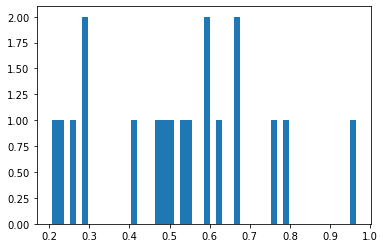

In [52]:
plt.hist(y_pred_prob_list, bins=50)

In [53]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes']

In [54]:
good, bad

(13, 6)

## Log Data

In [55]:
log_data = adata_cardiac.to_df('log.data')
colnames = log_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [56]:
df_log = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i), :].to_df(layer='log.data')
    df_log.loc[i]=np.mean(row)
    
df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,0.008157,0.175639,0.001275,0.054704,0.009222,0.015991,0.001913,0.000000,0.000000,0.000000,...,0.001594,0.000319,0.000319,0.000319,0.000319,0.0,0.000638,0.000000,0.001594,0.000000
18499,0.003995,0.059263,0.000000,0.031051,0.006579,0.027928,0.002759,0.000000,0.000000,0.000000,...,0.000690,0.001379,0.000000,0.000000,0.001035,0.0,0.002473,0.001035,0.002069,0.000000
18505,0.011980,0.066612,0.002163,0.043630,0.004248,0.003261,0.001631,0.000000,0.000000,0.001897,...,0.002806,0.002274,0.000000,0.000455,0.000000,0.0,0.001631,0.000721,0.001364,0.000000
18508,0.021178,0.283643,0.020196,0.185385,0.018196,0.065277,0.012285,0.016341,0.001927,0.002447,...,0.003737,0.001324,0.001005,0.000603,0.000603,0.0,0.003889,0.000000,0.004223,0.000000
18511,0.030839,0.722181,0.003961,0.254535,0.057813,0.055122,0.004446,0.001981,0.000000,0.000342,...,0.003240,0.000216,0.000864,0.001296,0.000648,0.0,0.004516,0.000901,0.003672,0.000216


In [57]:
samples = list(df_log.index)
feature_list = list(df_log.columns)
cm_biased=["18520", "19093", "18508", "18511", "18907", "19190", "18855", "19159", "19193", "19127"]
df_log['cm_biased'] = np.where(np.isin(df_log.index, cm_biased), 1, 0)
df_log['cm_not_biased'] = np.where(np.isin(df_log.index, cm_biased, invert=True), 1, 0)
df_log.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased
18489,0.008157,0.175639,0.001275,0.054704,0.009222,0.015991,0.001913,0.000000,0.000000,0.000000,...,0.000319,0.000319,0.000319,0.0,0.000638,0.000000,0.001594,0.000000,0,1
18499,0.003995,0.059263,0.000000,0.031051,0.006579,0.027928,0.002759,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001035,0.0,0.002473,0.001035,0.002069,0.000000,0,1
18505,0.011980,0.066612,0.002163,0.043630,0.004248,0.003261,0.001631,0.000000,0.000000,0.001897,...,0.000000,0.000455,0.000000,0.0,0.001631,0.000721,0.001364,0.000000,0,1
18508,0.021178,0.283643,0.020196,0.185385,0.018196,0.065277,0.012285,0.016341,0.001927,0.002447,...,0.001005,0.000603,0.000603,0.0,0.003889,0.000000,0.004223,0.000000,1,0
18511,0.030839,0.722181,0.003961,0.254535,0.057813,0.055122,0.004446,0.001981,0.000000,0.000342,...,0.000864,0.001296,0.000648,0.0,0.004516,0.000901,0.003672,0.000216,1,0


In [58]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [59]:
diff_measure = 'cm_biased'
x = df_log.loc[samples,feature_list].values
y = df_log.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)
    
predictions

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

In [60]:
y_pred_prob_list

[0.515658741272277,
 0.5327669289207403,
 0.5740939466738062,
 0.568712887339368,
 0.5617431188644278,
 0.5614842910649205,
 0.5053295914820439,
 0.5160876419104232,
 0.6004895368859847,
 0.5043903127973343,
 0.5150056513571742,
 0.6291485845140941,
 0.5203282942359699,
 0.5274565678137061,
 0.442259949548413,
 0.5655231543242364,
 0.5374965383389003,
 0.5002457271878256,
 0.5010635437876672]

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
        0., 0., 3., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 2., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.44225995, 0.44599772, 0.44973549, 0.45347327, 0.45721104,
        0.46094881, 0.46468659, 0.46842436, 0.47216213, 0.4758999 ,
        0.47963768, 0.48337545, 0.48711322, 0.49085099, 0.49458877,
        0.49832654, 0.50206431, 0.50580209, 0.50953986, 0.51327763,
        0.5170154 , 0.52075318, 0.52449095, 0.52822872, 0.53196649,
        0.53570427, 0.53944204, 0.54317981, 0.54691759, 0.55065536,
        0.55439313, 0.5581309 , 0.56186868, 0.56560645, 0.56934422,
        0.57308199, 0.57681977, 0.58055754, 0.58429531, 0.58803308,
        0.59177086, 0.59550863, 0.5992464 , 0.60298418, 0.60672195,
        0.61045972, 0.61419749, 0.61793527, 0.62167304, 0.62541081,
        0.62914858]),
 <BarContainer object of 50 artists>)

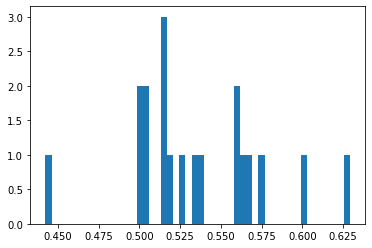

In [61]:
plt.hist(y_pred_prob_list, bins=50)

In [62]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'no']

In [63]:
good, bad

(9, 10)

# Based on D7-15

The above methods consider only a single time point and do not properly account for the changing cell type proportions 

In [81]:
scale_data = adata_cardiac.to_df('scale.data')
colnames = scale_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [82]:
df = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day0") & (adata_cardiac.obs['individual'] ==i) & (adata_cardiac.obs['type'] =="IPSC"), :].to_df()
    df.loc[i]=np.mean(row)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,-0.111766,-0.219152,-0.155414,-0.271091,-0.127420,-0.228374,-0.186682,-0.124309,-0.072244,-0.108559,...,-0.123529,-0.066350,-0.038419,-0.097456,-0.085249,-0.013725,-0.220073,-0.046136,-0.143138,-0.070124
18499,-0.142830,-0.254178,-0.168899,-0.287397,-0.137319,-0.234584,-0.187721,-0.144613,-0.089527,-0.120617,...,-0.150680,-0.060628,-0.051454,-0.114768,-0.088694,-0.013948,-0.239703,0.001986,-0.158127,-0.075768
18505,-0.093374,-0.245636,-0.128009,-0.276044,-0.135503,-0.239947,-0.169922,-0.118469,-0.078807,-0.084398,...,-0.131327,-0.024532,-0.049621,-0.106515,-0.085005,-0.013301,-0.248242,-0.028169,-0.146555,-0.072379
18508,-0.063418,-0.205842,0.034336,-0.236768,-0.120509,-0.209893,-0.133320,0.064625,-0.035818,-0.086366,...,-0.107500,-0.048671,-0.029379,-0.099088,-0.079364,-0.014141,-0.206241,-0.048564,-0.126072,-0.072492
18511,-0.026022,-0.079268,-0.147691,-0.218229,-0.078380,-0.217070,-0.190798,-0.126174,-0.084377,-0.117036,...,-0.122138,-0.069944,-0.025345,-0.090372,-0.084530,-0.014103,-0.209586,-0.035310,-0.136883,-0.065485


In [83]:
samples = list(df.index)
feature_list = list(df.columns)

In [84]:
cm_biased=["18508", "18511", "18520", "18855", "18907", "19093", "19127", "19159", "19190", "19193"]
df['cm_biased'] = np.where(np.isin(df.index, cm_biased), 1, 0)
df['cm_not_biased'] = np.where(np.isin(df.index, cm_biased, invert=True), 1, 0)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased
18489,-0.111766,-0.219152,-0.155414,-0.271091,-0.127420,-0.228374,-0.186682,-0.124309,-0.072244,-0.108559,...,-0.038419,-0.097456,-0.085249,-0.013725,-0.220073,-0.046136,-0.143138,-0.070124,0,1
18499,-0.142830,-0.254178,-0.168899,-0.287397,-0.137319,-0.234584,-0.187721,-0.144613,-0.089527,-0.120617,...,-0.051454,-0.114768,-0.088694,-0.013948,-0.239703,0.001986,-0.158127,-0.075768,0,1
18505,-0.093374,-0.245636,-0.128009,-0.276044,-0.135503,-0.239947,-0.169922,-0.118469,-0.078807,-0.084398,...,-0.049621,-0.106515,-0.085005,-0.013301,-0.248242,-0.028169,-0.146555,-0.072379,0,1
18508,-0.063418,-0.205842,0.034336,-0.236768,-0.120509,-0.209893,-0.133320,0.064625,-0.035818,-0.086366,...,-0.029379,-0.099088,-0.079364,-0.014141,-0.206241,-0.048564,-0.126072,-0.072492,1,0
18511,-0.026022,-0.079268,-0.147691,-0.218229,-0.078380,-0.217070,-0.190798,-0.126174,-0.084377,-0.117036,...,-0.025345,-0.090372,-0.084530,-0.014103,-0.209586,-0.035310,-0.136883,-0.065485,1,0


In [85]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [86]:
diff_measure = 'cm_biased'
x = df.loc[samples,feature_list].values
y = df.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

In [87]:
y_pred_prob_list

[0.6469884701170164,
 0.20919574320281037,
 0.5051391098650838,
 0.672458803301513,
 0.5304464639567831,
 0.40429941563950517,
 0.26010297567682306,
 0.2914740836789325,
 0.7532079227589294,
 0.27258491979979327,
 0.8037645962219314,
 0.586107971927242,
 0.4416584609543697,
 0.4962306565066875,
 0.5385798666751185,
 0.9668228850376323,
 0.6654777946224923,
 0.6537194455325078,
 0.23857701596748115]

(array([1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 0., 1., 1., 2., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.20919574, 0.22434829, 0.23950083, 0.25465337, 0.26980591,
        0.28495846, 0.300111  , 0.31526354, 0.33041609, 0.34556863,
        0.36072117, 0.37587371, 0.39102626, 0.4061788 , 0.42133134,
        0.43648389, 0.45163643, 0.46678897, 0.48194151, 0.49709406,
        0.5122466 , 0.52739914, 0.54255169, 0.55770423, 0.57285677,
        0.58800931, 0.60316186, 0.6183144 , 0.63346694, 0.64861949,
        0.66377203, 0.67892457, 0.69407711, 0.70922966, 0.7243822 ,
        0.73953474, 0.75468729, 0.76983983, 0.78499237, 0.80014491,
        0.81529746, 0.83045   , 0.84560254, 0.86075509, 0.87590763,
        0.89106017, 0.90621271, 0.92136526, 0.9365178 , 0.95167034,
        0.96682289]),
 <BarContainer object of 50 artists>)

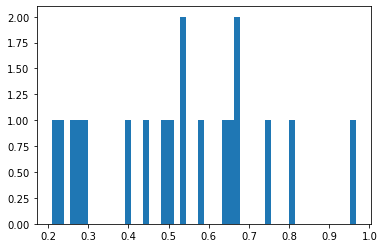

In [88]:
plt.hist(y_pred_prob_list, bins=50)

In [89]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes']

In [90]:
good, bad

(12, 7)

Identifiyng top coeficients: 

In [91]:
idx = (-model.coef_).argsort()
features_array=np.asarray(feature_list)
desc_feature = [features_array[i] for i in idx]
desc_feature

[array(['MT-ND4L', 'MT1G', 'MTND4P12', 'MT1X', 'AASS', 'ATP6V0D2', 'MSRB3',
        'AC010542.4', 'IFITM3', 'ADAMTS1', 'CFC1', 'EDNRA', 'SIX3',
        'AKR1D1', 'HOXA11-AS', 'FTL', 'HOXA-AS3', 'HPR', 'MT-ATP6',
        'EPCAM', 'CLIC5', 'WT1', 'LDHA', 'PEX5L-AS2', 'GRIK1', 'CFAP126',
        'FIBIN', 'MECOM', 'VTN', 'CCBE1', 'GADD45A', 'ITGB1BP2', 'AFP',
        'ADM', 'MME', 'PLAGL1', 'SLC28A2', 'DLX5', 'KLHL41', 'HOXC8',
        'LINC01972', 'FGF5', 'BTNL9', 'RCAN1', 'MT-ND1', 'C1orf105',
        'RRAD', 'LGI1', 'TTC3', 'PRPH', 'ADRB3', 'LIMCH1', 'PABPC1',
        'HIST1H1C', 'LRRC53', 'FYB2', 'SPARCL1', 'Z99496.2', 'CST2',
        'CENPE', 'MYLK3', 'CNTN4', 'RIPPLY3', 'MT1E', 'STK26', 'PCDH9',
        'CCL21', 'RSPO1', 'TPX2', 'CGNL1', 'AC245060.5', 'AL353751.1',
        'CLCN6', 'GAS5', 'CDKN1A', 'MEOX1', 'HOXB9', 'SLC5A12', 'GJA4',
        'RPS12', 'FGF17', 'AC245041.2', 'JAG1', 'ALPG', 'LGALS1',
        'LINC02268', 'NOSTRIN', 'HOXB5', 'LINC00348', 'COL6A4P2', 'FAM24B',
        

# Predicting on D3 CMES

In [26]:
scale_data = adata_cardiac.to_df('scale.data')
colnames = scale_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [27]:
df = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day3") & (adata_cardiac.obs['individual'] ==i) & (adata_cardiac.obs['type'] =="CMES"), :].to_df()
    df.loc[i]=np.mean(row)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,-0.124034,-0.245068,-0.069588,-0.261205,-0.120681,-0.218758,-0.120911,-0.056660,-0.041756,-0.054995,...,-0.111346,-0.063320,-0.040586,-0.092377,0.000732,-0.012773,-0.023775,-0.010839,-0.080723,-0.060378
18499,-0.099265,-0.204244,0.166892,-0.232987,-0.109336,-0.202442,-0.040091,0.062043,-0.015826,-0.015469,...,-0.106633,-0.054035,-0.034976,-0.078816,-0.064397,-0.011614,-0.003559,-0.034110,-0.032000,-0.052069
18505,-0.104084,-0.247125,0.355132,-0.261869,-0.114097,-0.217741,-0.045783,-0.005523,-0.027078,0.028671,...,-0.092773,-0.058965,-0.037983,-0.086234,-0.037335,-0.012062,0.032306,-0.037260,-0.118158,-0.055722
18508,-0.134165,-0.254127,-0.106835,-0.228181,-0.026356,-0.203434,-0.148865,-0.082766,-0.054769,-0.072258,...,-0.126250,-0.068313,-0.015454,-0.096857,-0.043267,-0.013393,0.018322,-0.044777,-0.095519,-0.064561
18511,-0.149615,-0.256984,0.505394,-0.283441,-0.137138,-0.238495,-0.164765,-0.108853,-0.070534,-0.091747,...,-0.118613,-0.074533,-0.047380,-0.108965,-0.051124,-0.013734,-0.152785,-0.049133,-0.153647,-0.069650


In [28]:
samples = list(df.index)
feature_list = list(df.columns)

In [29]:
cm_biased=["18508", "18511", "18520", "18855", "18907", "19093", "19127", "19159", "19190", "19193"]
df['cm_biased'] = np.where(np.isin(df.index, cm_biased), 1, 0)
df['cm_not_biased'] = np.where(np.isin(df.index, cm_biased, invert=True), 1, 0)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased
18489,-0.124034,-0.245068,-0.069588,-0.261205,-0.120681,-0.218758,-0.120911,-0.056660,-0.041756,-0.054995,...,-0.040586,-0.092377,0.000732,-0.012773,-0.023775,-0.010839,-0.080723,-0.060378,0,1
18499,-0.099265,-0.204244,0.166892,-0.232987,-0.109336,-0.202442,-0.040091,0.062043,-0.015826,-0.015469,...,-0.034976,-0.078816,-0.064397,-0.011614,-0.003559,-0.034110,-0.032000,-0.052069,0,1
18505,-0.104084,-0.247125,0.355132,-0.261869,-0.114097,-0.217741,-0.045783,-0.005523,-0.027078,0.028671,...,-0.037983,-0.086234,-0.037335,-0.012062,0.032306,-0.037260,-0.118158,-0.055722,0,1
18508,-0.134165,-0.254127,-0.106835,-0.228181,-0.026356,-0.203434,-0.148865,-0.082766,-0.054769,-0.072258,...,-0.015454,-0.096857,-0.043267,-0.013393,0.018322,-0.044777,-0.095519,-0.064561,1,0
18511,-0.149615,-0.256984,0.505394,-0.283441,-0.137138,-0.238495,-0.164765,-0.108853,-0.070534,-0.091747,...,-0.047380,-0.108965,-0.051124,-0.013734,-0.152785,-0.049133,-0.153647,-0.069650,1,0


In [30]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [31]:
diff_measure = 'cm_biased'
x = df.loc[samples,feature_list].values
y = df.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

In [32]:
y_pred_prob_list

[0.41357265522743797,
 0.042435415334110195,
 0.0705756249598389,
 0.8716751889299166,
 0.0805231461847955,
 0.3080666922808952,
 0.27399084076803754,
 0.6349897879761065,
 0.4468871576482126,
 0.12578756423590867,
 0.639257517841784,
 0.33448460653761697,
 0.7084886930795655,
 0.6725338000644826,
 0.7559012291541413,
 0.9177071918194794,
 0.8524188780897594,
 0.8821225378097165,
 0.25725851717475823]

(array([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 2., 0., 1.]),
 array([0.04243542, 0.05994085, 0.07744629, 0.09495172, 0.11245716,
        0.12996259, 0.14746803, 0.16497346, 0.1824789 , 0.19998434,
        0.21748977, 0.23499521, 0.25250064, 0.27000608, 0.28751151,
        0.30501695, 0.32252238, 0.34002782, 0.35753325, 0.37503869,
        0.39254413, 0.41004956, 0.427555  , 0.44506043, 0.46256587,
        0.4800713 , 0.49757674, 0.51508217, 0.53258761, 0.55009305,
        0.56759848, 0.58510392, 0.60260935, 0.62011479, 0.63762022,
        0.65512566, 0.67263109, 0.69013653, 0.70764197, 0.7251474 ,
        0.74265284, 0.76015827, 0.77766371, 0.79516914, 0.81267458,
        0.83018001, 0.84768545, 0.86519089, 0.88269632, 0.90020176,
        0.91770719]),
 <BarContainer object of 50 artists>)

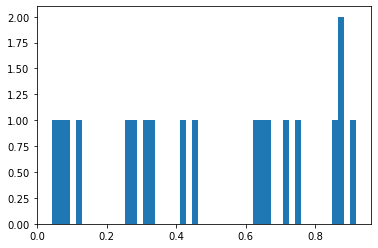

In [33]:
plt.hist(y_pred_prob_list, bins=50)

In [34]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes']

In [35]:
good, bad

(16, 3)

In [36]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [87]:
#model.coef_

In [73]:
features_array=np.asarray(feature_list)

In [74]:
desc_feature = [features_array[i] for i in idx]
desc_feature[0]

array(['BMP4', 'SOX17', 'GYPE', 'AFP', 'ATP6V0D2', 'MSRB3', 'AC010542.4',
       'IFITM3', 'ADAMTS1', 'CFC1', 'EDNRA', 'SIX3', 'MTND4P12', 'AKR1D1',
       'HOXA11-AS', 'MT1X', 'FTL', 'HOXA-AS3', 'HPR', 'MT-ATP6', 'EPCAM',
       'CLIC5', 'WT1', 'LDHA', 'PEX5L-AS2', 'GRIK1', 'CFAP126', 'FIBIN',
       'MECOM', 'GADD45A', 'ITGB1BP2', 'RIPPLY3', 'ADM', 'MME', 'PLAGL1',
       'SLC28A2', 'DLX5', 'KLHL41', 'HOXC8', 'LINC01972', 'FGF5', 'BTNL9',
       'RCAN1', 'MT-ND1', 'C1orf105', 'RRAD', 'LGI1', 'TTC3', 'PRPH',
       'ADRB3', 'LIMCH1', 'PABPC1', 'HIST1H1C', 'LRRC53', 'FYB2',
       'SPARCL1', 'Z99496.2', 'CST2', 'CENPE', 'MYLK3', 'VTN', 'CCBE1',
       'CNTN4', 'MT1E', 'POLR3G', 'PCDH9', 'CCL21', 'RSPO1', 'TPX2',
       'CGNL1', 'AC245060.5', 'AL353751.1', 'CLCN6', 'GAS5', 'CDKN1A',
       'MEOX1', 'HOXB9', 'SLC5A12', 'GJA4', 'RPS12', 'FGF17',
       'AC245041.2', 'JAG1', 'ALPG', 'LGALS1', 'LINC02268', 'NOSTRIN',
       'HOXB5', 'LINC00348', 'COL6A4P2', 'FAM24B', 'CARMN', 'PPFIA2',
    

In [80]:
model.coef_[0][416]

2.042445419268458

# Using D1 MES

In [3]:
scale_data = adata_cardiac.to_df('scale.data')
colnames = scale_data.columns
individuals = np.unique(adata_cardiac.obs["individual"])

In [4]:
df = pd.DataFrame(columns=colnames)
for i in individuals:
    row = adata_cardiac[(adata_cardiac.obs['diffday'] =="day1") & (adata_cardiac.obs['individual'] ==i) & (adata_cardiac.obs['type'] =="MES"), :].to_df()
    df.loc[i]=np.mean(row)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,MITF,FGF9,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3
18489,-0.124946,-0.253670,-0.109389,-0.275524,-0.132541,-0.229427,-0.132206,-0.089602,-0.057101,-0.071799,...,-0.129842,-0.056752,-0.028011,-0.087637,-0.065926,-0.013019,-0.213553,-0.045381,-0.122299,-0.065303
18499,-0.122178,-0.247144,-0.066963,-0.272323,-0.127680,-0.224068,-0.119597,-0.055506,-0.043471,-0.049096,...,-0.121987,-0.063031,-0.041644,-0.089243,-0.064605,-0.012617,-0.184490,-0.027427,-0.107739,-0.060989
18505,-0.118995,-0.248132,-0.061102,-0.274252,-0.130552,-0.228803,-0.108033,-0.066301,-0.050671,-0.053561,...,-0.132783,-0.059163,-0.043452,-0.085522,-0.078242,-0.012641,-0.206542,-0.037414,-0.129164,-0.042530
18508,-0.146862,-0.251479,-0.150147,-0.279328,-0.135784,-0.226790,-0.189031,-0.033432,-0.080083,-0.116510,...,-0.143549,-0.068780,-0.048576,-0.101170,-0.092930,-0.013769,-0.206926,-0.051644,-0.159068,-0.072673
18511,-0.163342,-0.263812,-0.174356,-0.294543,-0.144605,-0.249732,-0.204810,-0.158717,-0.099002,-0.130370,...,-0.164171,-0.072223,-0.045715,-0.110307,-0.095026,-0.014290,-0.247205,-0.050763,-0.168188,-0.078835


In [5]:
samples = list(df.index)
feature_list = list(df.columns)

In [6]:
cm_biased=["18508", "18511", "18520", "18855", "18907", "19093", "19127", "19159", "19190", "19193"]
df['cm_biased'] = np.where(np.isin(df.index, cm_biased), 1, 0)
df['cm_not_biased'] = np.where(np.isin(df.index, cm_biased, invert=True), 1, 0)
df.head()

,AFP,EMC10,APOA2,MYL7,NPPA,ANKRD1,APOA1,TTR,SERPINA1,FGB,...,TMEM176B,ARHGDIB,GIPR,FABP2,ZEB1,AKR1C2,AUXG01000058.1,CLIC3,cm_biased,cm_not_biased
18489,-0.124946,-0.253670,-0.109389,-0.275524,-0.132541,-0.229427,-0.132206,-0.089602,-0.057101,-0.071799,...,-0.028011,-0.087637,-0.065926,-0.013019,-0.213553,-0.045381,-0.122299,-0.065303,0,1
18499,-0.122178,-0.247144,-0.066963,-0.272323,-0.127680,-0.224068,-0.119597,-0.055506,-0.043471,-0.049096,...,-0.041644,-0.089243,-0.064605,-0.012617,-0.184490,-0.027427,-0.107739,-0.060989,0,1
18505,-0.118995,-0.248132,-0.061102,-0.274252,-0.130552,-0.228803,-0.108033,-0.066301,-0.050671,-0.053561,...,-0.043452,-0.085522,-0.078242,-0.012641,-0.206542,-0.037414,-0.129164,-0.042530,0,1
18508,-0.146862,-0.251479,-0.150147,-0.279328,-0.135784,-0.226790,-0.189031,-0.033432,-0.080083,-0.116510,...,-0.048576,-0.101170,-0.092930,-0.013769,-0.206926,-0.051644,-0.159068,-0.072673,1,0
18511,-0.163342,-0.263812,-0.174356,-0.294543,-0.144605,-0.249732,-0.204810,-0.158717,-0.099002,-0.130370,...,-0.045715,-0.110307,-0.095026,-0.014290,-0.247205,-0.050763,-0.168188,-0.078835,1,0


In [7]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [8]:
diff_measure = 'cm_biased'
x = df.loc[samples,feature_list].values
y = df.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,1000))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0])]

In [9]:
y_pred_prob_list

[0.4838550379739159,
 0.3858783137855696,
 0.5377799547020955,
 0.36479073775263365,
 0.5332809567914308,
 0.3631014679414353,
 0.41744251586835573,
 0.4320474645555058,
 0.5062156352625574,
 0.4026843034554615,
 0.40578853369984563,
 0.46491888278264204,
 0.3967037191617436,
 0.36657868428164136,
 0.40571520287288076,
 0.3175643115822289,
 0.6024616331424327,
 0.8902716100621076,
 0.4703565006611332]

(array([1., 0., 0., 1., 2., 1., 1., 3., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.31756431, 0.32901846, 0.3404726 , 0.35192675, 0.3633809 ,
        0.37483504, 0.38628919, 0.39774333, 0.40919748, 0.42065163,
        0.43210577, 0.44355992, 0.45501406, 0.46646821, 0.47792236,
        0.4893765 , 0.50083065, 0.51228479, 0.52373894, 0.53519309,
        0.54664723, 0.55810138, 0.56955552, 0.58100967, 0.59246381,
        0.60391796, 0.61537211, 0.62682625, 0.6382804 , 0.64973454,
        0.66118869, 0.67264284, 0.68409698, 0.69555113, 0.70700527,
        0.71845942, 0.72991357, 0.74136771, 0.75282186, 0.764276  ,
        0.77573015, 0.7871843 , 0.79863844, 0.81009259, 0.82154673,
        0.83300088, 0.84445503, 0.85590917, 0.86736332, 0.87881746,
        0.89027161]),
 <BarContainer object of 50 artists>)

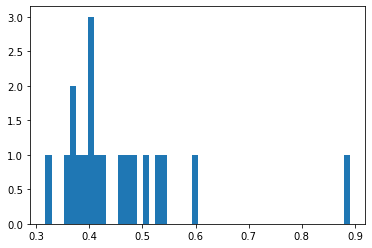

In [10]:
plt.hist(y_pred_prob_list, bins=50)

In [11]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['yes',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'yes',
 'yes']

In [12]:
good, bad

(10, 9)

# Using Bulk and Pseudobulk Data

In [64]:
bulk_and_pseudo = pd.read_csv("d0_data.csv", index_col=0)
bulk_and_pseudo_T = bulk_and_pseudo.transpose()
bulk_and_pseudo_T.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,...,ZSWIM7,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
bulk_18489_0,0.289182,0.578365,1.098893,10.410566,40.890389,0.000000,81.954288,90.803269,0.0,1.041057,...,22.614063,44.071396,28.397710,59.398062,77.153860,24.349157,6.998214,35.048905,153.324501,47.715094
bulk_18499_0,0.467769,0.601418,0.167060,13.197773,20.381371,0.267297,86.604122,60.776581,0.0,0.267297,...,22.118800,52.857917,26.462371,52.757681,64.986504,26.495783,2.439082,25.994602,188.945336,42.199462
bulk_18505_0,0.289239,0.607402,0.954488,12.350498,14.433018,0.086772,74.450076,70.256113,0.0,0.347087,...,18.279894,50.616796,30.688240,54.955378,70.024722,41.476849,2.805617,29.675904,171.316161,46.798843
bulk_18508_0,0.315359,0.578158,0.315359,16.871689,15.400015,0.262799,63.019175,65.699724,0.0,0.420478,...,27.541324,63.649892,29.959074,59.182311,88.247869,31.378188,2.312630,26.910607,151.634963,53.926333
bulk_18511_0,0.215433,0.553970,0.738626,4.400980,17.080727,0.030776,69.492399,58.597665,0.0,0.677074,...,18.434875,50.011138,23.420600,55.704713,88.142707,26.713642,3.385369,23.174392,183.579345,39.485717


In [65]:
samples = list(bulk_and_pseudo_T.index)
feature_list = list(bulk_and_pseudo_T.columns)

In [66]:
cm_biased_bulk=["18489", "18505", "18508", "18511", "18517", "18858", "18912", "19108", "19159", "19190", "19193", "19209"]
cm_biased_pseudo=["18489", "18499", "18505", "18517", "18858", "18870", "18912", "19209"]
cm_biased_bulk_and_pseudo = []
for i in cm_biased_bulk:
    cm_biased_bulk_and_pseudo.append("bulk_"+i+"_0")
for i in cm_biased_pseudo:
    cm_biased_bulk_and_pseudo.append("pseudobulk_"+i+"_0")
cm_biased_bulk_and_pseudo
bulk_and_pseudo_T['cm_biased'] = np.where(np.isin(bulk_and_pseudo_T.index, cm_biased_bulk_and_pseudo), 1, 0)
bulk_and_pseudo_T['cm_not_biased'] = np.where(np.isin(bulk_and_pseudo_T.index, cm_biased_bulk_and_pseudo, invert=True), 1, 0)
bulk_and_pseudo_T.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,...,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,cm_biased,cm_not_biased
bulk_18489_0,0.289182,0.578365,1.098893,10.410566,40.890389,0.000000,81.954288,90.803269,0.0,1.041057,...,28.397710,59.398062,77.153860,24.349157,6.998214,35.048905,153.324501,47.715094,1,0
bulk_18499_0,0.467769,0.601418,0.167060,13.197773,20.381371,0.267297,86.604122,60.776581,0.0,0.267297,...,26.462371,52.757681,64.986504,26.495783,2.439082,25.994602,188.945336,42.199462,0,1
bulk_18505_0,0.289239,0.607402,0.954488,12.350498,14.433018,0.086772,74.450076,70.256113,0.0,0.347087,...,30.688240,54.955378,70.024722,41.476849,2.805617,29.675904,171.316161,46.798843,1,0
bulk_18508_0,0.315359,0.578158,0.315359,16.871689,15.400015,0.262799,63.019175,65.699724,0.0,0.420478,...,29.959074,59.182311,88.247869,31.378188,2.312630,26.910607,151.634963,53.926333,1,0
bulk_18511_0,0.215433,0.553970,0.738626,4.400980,17.080727,0.030776,69.492399,58.597665,0.0,0.677074,...,23.420600,55.704713,88.142707,26.713642,3.385369,23.174392,183.579345,39.485717,1,0


In [67]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [68]:
diff_measure = 'cm_biased'
x = bulk_and_pseudo_T.loc[samples,feature_list].values
y = bulk_and_pseudo_T.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,15336))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1])]

In [69]:
y_pred_prob_list

[0.2661632742734987,
 0.9998026146190938,
 0.5463914124475044,
 0.9973851538679137,
 0.9984596446990714,
 0.9956885167700398,
 0.017865627803398492,
 0.0462158009614765,
 0.22922756731499744,
 0.044163185832816004,
 0.9999301637033974,
 0.012133679166578565,
 0.9952033797589571,
 0.9977276194837583,
 0.9809428218515435,
 0.1999279492060148,
 0.5367512946533485,
 0.13777589581670371,
 0.5012220488741824,
 0.6313193900983199,
 0.09639926868781376,
 0.9983940491531762,
 0.0048431807448253116,
 0.9999417230129073,
 0.7991164403859823,
 0.9642084738647897,
 0.9929687965398835,
 0.01091427725451728,
 0.1635064003806112,
 7.483623967702122e-05,
 0.9459821506380469,
 3.91546779772131e-09,
 0.030263226161951876,
 0.9706197144181167,
 6.999726530085485e-10,
 4.0194718121486824e-05,
 0.9915636744083335,
 0.9999980959454707]

(array([ 8.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2., 13.]),
 array([6.99972653e-10, 1.99999626e-02, 3.99999245e-02, 5.99998864e-02,
        7.99998483e-02, 9.99998102e-02, 1.19999772e-01, 1.39999734e-01,
        1.59999696e-01, 1.79999658e-01, 1.99999620e-01, 2.19999582e-01,
        2.39999544e-01, 2.59999505e-01, 2.79999467e-01, 2.99999429e-01,
        3.19999391e-01, 3.39999353e-01, 3.59999315e-01, 3.79999277e-01,
        3.99999239e-01, 4.19999201e-01, 4.39999163e-01, 4.59999125e-01,
        4.79999086e-01, 4.99999048e-01, 5.19999010e-01, 5.39998972e-01,
        5.59998934e-01, 5.79998896e-01, 5.99998858e-01, 6.19998820e-01,
        6.39998782e-01, 6.59998744e-01, 6.79998705e-01, 6.99998667e-01,
        7.19998629e-01, 7.39998591e-01, 7.59998553e-01, 7.79998515e-

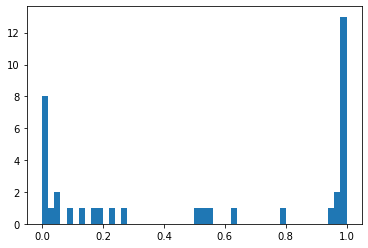

In [70]:
plt.hist(y_pred_prob_list, bins=50)

In [71]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'no',
 'yes']

In [72]:
good, bad

(21, 17)

In [73]:
idx = (-model.coef_).argsort()
features_array=np.asarray(feature_list)
desc_feature = [features_array[i] for i in idx]
desc_feature

[array(['INPP5F', 'B2M', 'ADCY2', ..., 'EDNRB', 'TNC', 'MT1G'],
       dtype='<U15')]

(0.0, 1.01)

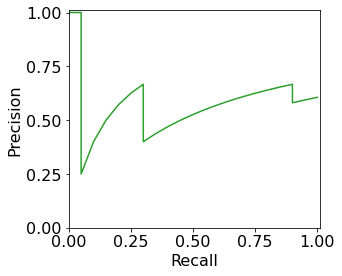

In [74]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
fig = plt.figure(figsize=(4.5,4))

plt.plot(recall, precision, '-', color='#2ca02c')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(np.arange(0,1.01,0.25), fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
plt.xlim([0,1.01])
plt.ylim([0.0,1.01])

# Just Pseudobulk

In [75]:
bulk_and_pseudo = pd.read_csv("d0_data.csv", index_col=0)
bulk_and_pseudo_T = bulk_and_pseudo.transpose()
bulk_and_pseudo_T.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,...,ZSWIM7,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
bulk_18489_0,0.289182,0.578365,1.098893,10.410566,40.890389,0.000000,81.954288,90.803269,0.0,1.041057,...,22.614063,44.071396,28.397710,59.398062,77.153860,24.349157,6.998214,35.048905,153.324501,47.715094
bulk_18499_0,0.467769,0.601418,0.167060,13.197773,20.381371,0.267297,86.604122,60.776581,0.0,0.267297,...,22.118800,52.857917,26.462371,52.757681,64.986504,26.495783,2.439082,25.994602,188.945336,42.199462
bulk_18505_0,0.289239,0.607402,0.954488,12.350498,14.433018,0.086772,74.450076,70.256113,0.0,0.347087,...,18.279894,50.616796,30.688240,54.955378,70.024722,41.476849,2.805617,29.675904,171.316161,46.798843
bulk_18508_0,0.315359,0.578158,0.315359,16.871689,15.400015,0.262799,63.019175,65.699724,0.0,0.420478,...,27.541324,63.649892,29.959074,59.182311,88.247869,31.378188,2.312630,26.910607,151.634963,53.926333
bulk_18511_0,0.215433,0.553970,0.738626,4.400980,17.080727,0.030776,69.492399,58.597665,0.0,0.677074,...,18.434875,50.011138,23.420600,55.704713,88.142707,26.713642,3.385369,23.174392,183.579345,39.485717


In [76]:
pseudo = bulk_and_pseudo_T.drop(bulk_and_pseudo_T.index[0:19])
pseudo

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,...,ZSWIM7,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
pseudobulk_18489_0,0.758471,0.000000,0.000000,1.896178,12.514775,0.0,55.368398,38.682032,0.0,0.000000,...,120.976157,4.930063,34.889675,142.592587,112.632974,4.930063,1.516942,34.510440,81.535655,8.722419
pseudobulk_18499_0,3.915412,0.391541,0.000000,2.740788,7.830823,0.0,56.381927,27.407881,0.0,0.000000,...,105.324572,2.349247,29.757128,120.203136,72.435114,6.656200,0.391541,35.630245,91.620631,6.264659
pseudobulk_18505_0,1.003949,0.000000,0.000000,7.027640,7.529614,0.0,40.157943,31.624380,0.0,0.000000,...,78.809963,3.011846,27.608586,146.074517,60.236914,7.529614,2.007897,22.588843,58.730991,7.529614
pseudobulk_18508_0,2.688839,0.413668,0.413668,2.482005,5.998179,0.0,24.820053,40.953088,0.0,0.206834,...,197.319422,7.859683,36.609578,124.100265,91.627363,5.584512,0.827335,41.159921,54.604117,8.687019
pseudobulk_18511_0,1.488170,0.496057,0.992113,2.232254,2.728311,0.0,37.452267,26.290996,0.0,0.000000,...,92.018485,5.704650,36.460154,182.796829,115.581170,8.184933,1.736198,27.283109,93.506655,6.944791
pseudobulk_18517_0,1.762510,0.440628,0.440628,3.525021,3.525021,0.0,50.231544,27.759537,0.0,0.000000,...,132.188273,6.609414,41.418992,161.269694,98.259950,4.406276,0.881255,27.318910,80.194219,8.812552
pseudobulk_18520_0,0.000000,0.000000,0.000000,6.492248,3.246124,0.0,40.576548,22.722867,0.0,0.000000,...,181.782933,3.246124,24.345929,118.483519,129.844952,6.492248,0.000000,40.576548,77.906971,9.738371
pseudobulk_18855_0,1.835772,0.000000,0.000000,2.753659,9.178862,0.0,31.208132,31.208132,0.0,0.000000,...,93.624396,10.096749,44.976425,179.905702,95.460168,7.343090,7.343090,38.551222,44.976425,5.507317
pseudobulk_18858_0,1.050736,0.350245,0.700490,8.055640,6.304414,0.0,38.176729,36.775748,0.0,0.700490,...,92.464738,8.405885,32.222560,130.641467,84.058853,13.659564,0.350245,33.273296,68.648063,5.253678
pseudobulk_18870_0,0.961415,0.240354,0.000000,2.643891,4.566721,0.0,46.868974,16.103699,0.0,0.000000,...,200.214644,3.124598,26.438909,109.120586,87.488752,5.768489,0.000000,37.975887,69.942931,4.326367


In [77]:
samples = list(pseudo.index)
feature_list = list(pseudo.columns)

In [78]:
cm_biased_pseudo=["18489", "18499", "18505", "18517", "18858", "18870", "18912", "19209"]
cm_bias = []
for i in cm_biased_pseudo:
    cm_bias.append("pseudobulk_"+i+"_0")
pseudo['cm_biased'] = np.where(np.isin(pseudo.index, cm_bias), 1, 0)
pseudo['cm_not_biased'] = np.where(np.isin(pseudo.index, cm_bias, invert=True), 1, 0)
pseudo.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,...,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,cm_biased,cm_not_biased
pseudobulk_18489_0,0.758471,0.000000,0.000000,1.896178,12.514775,0.0,55.368398,38.682032,0.0,0.000000,...,34.889675,142.592587,112.632974,4.930063,1.516942,34.510440,81.535655,8.722419,1,0
pseudobulk_18499_0,3.915412,0.391541,0.000000,2.740788,7.830823,0.0,56.381927,27.407881,0.0,0.000000,...,29.757128,120.203136,72.435114,6.656200,0.391541,35.630245,91.620631,6.264659,1,0
pseudobulk_18505_0,1.003949,0.000000,0.000000,7.027640,7.529614,0.0,40.157943,31.624380,0.0,0.000000,...,27.608586,146.074517,60.236914,7.529614,2.007897,22.588843,58.730991,7.529614,1,0
pseudobulk_18508_0,2.688839,0.413668,0.413668,2.482005,5.998179,0.0,24.820053,40.953088,0.0,0.206834,...,36.609578,124.100265,91.627363,5.584512,0.827335,41.159921,54.604117,8.687019,0,1
pseudobulk_18511_0,1.488170,0.496057,0.992113,2.232254,2.728311,0.0,37.452267,26.290996,0.0,0.000000,...,36.460154,182.796829,115.581170,8.184933,1.736198,27.283109,93.506655,6.944791,0,1


In [79]:
model = sklearn.linear_model.LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='liblinear')

In [80]:
diff_measure = 'cm_biased'
x = pseudo.loc[samples,feature_list].values
y = pseudo.loc[samples,diff_measure].values
n_samples = x.shape[0]
predictions=[]
y_test_list=[]
y_pred_prob_list=[]
for i in range(n_samples):
    X_train, Y_train = np.delete(x, i, 0), np.delete(y,i,0)
    X_test, Y_test = x[i,:], y[i]
    X_test = np.reshape(X_test, (1,15336))
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_list.append(Y_test)
    y_pred_prob_list.append(list(y_pred_prob)[0])
    
    predictions.append(y_pred)

predictions

[array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1])]

In [81]:
y_pred_prob_list

[0.002813672994499528,
 0.15897275378041,
 0.998828471254546,
 0.0007577825456354257,
 0.9919790778628969,
 0.9930269434974108,
 0.9739438910074447,
 0.9973704419799867,
 0.06880464850866451,
 0.7349999110050804,
 0.07776087407740533,
 0.07321614439755077,
 0.2692768424902105,
 0.002040518066523227,
 0.36103782558482245,
 2.42014681593223e-12,
 4.045499141717582e-10,
 0.9927958692231761,
 0.9999694460765229]

(array([5., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 6.]),
 array([2.42014682e-12, 1.99993889e-02, 3.99987778e-02, 5.99981668e-02,
        7.99975557e-02, 9.99969446e-02, 1.19996334e-01, 1.39995722e-01,
        1.59995111e-01, 1.79994500e-01, 1.99993889e-01, 2.19993278e-01,
        2.39992667e-01, 2.59992056e-01, 2.79991445e-01, 2.99990834e-01,
        3.19990223e-01, 3.39989612e-01, 3.59989001e-01, 3.79988390e-01,
        3.99987778e-01, 4.19987167e-01, 4.39986556e-01, 4.59985945e-01,
        4.79985334e-01, 4.99984723e-01, 5.19984112e-01, 5.39983501e-01,
        5.59982890e-01, 5.79982279e-01, 5.99981668e-01, 6.19981057e-01,
        6.39980445e-01, 6.59979834e-01, 6.79979223e-01, 6.99978612e-01,
        7.19978001e-01, 7.39977390e-01, 7.59976779e-01, 7.79976168e-01,
        7.99975557e-01, 8.19974946e-01, 8.39974335e-01

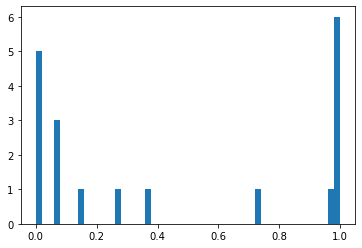

In [82]:
plt.hist(y_pred_prob_list, bins=50)

In [83]:
matches=[]
good=0
bad=0
for i in range(len(predictions)):
    if y[i] == predictions[i]:
        matches.append('yes')
        good+=1
    else:
        matches.append('no')
        bad+=1

matches

['no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes']

In [84]:
good, bad

(11, 8)

In [85]:
idx = (-model.coef_).argsort()
features_array=np.asarray(feature_list)
desc_feature = [features_array[i] for i in idx]
desc_feature

[array(['S100A11', 'B2M', 'MTRNR2L1', ..., 'BNIP3', 'SOX4', 'MT1G'],
       dtype='<U15')]

(0.0, 1.01)

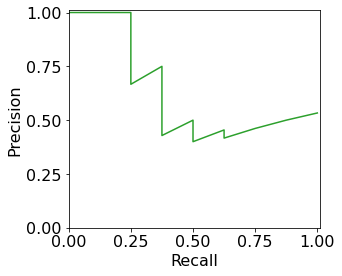

In [86]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test_list, y_pred_prob_list)
fig = plt.figure(figsize=(4.5,4))

plt.plot(recall, precision, '-', color='#2ca02c')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(np.arange(0,1.01,0.25), fontsize=16)
plt.yticks([0,0.25,0.5,0.75,1.0], fontsize=16)
plt.xlim([0,1.01])
plt.ylim([0.0,1.01])